# Parámetros globales del *Notebook*

In [1]:
# Para definir los path
import os

# Define si estamos ejecutando el Notebook en nuestro 
# ordenador ("local") o en Google Colab ("remote")
RUNNING_ENV = "remote"

# Path que vamos a usar como base para el resto de paths
BASE_PATH = "./" if RUNNING_ENV == "local" else "/content/drive/MyDrive/Colab Notebooks/"

# Directorio en el que guardamos los scripts de python que usamos 
# como libreria propia
LIB_PATH = os.path.join(BASE_PATH, "lib")

# Directorio en el que guardamos los datos de entrenamiento y test
DATA_PATH = os.path.join(BASE_PATH, "data")

# Numero de procesos que queremos usar
NUM_WORKERS = 2

# Batch size que queremos usar para los dataloaders que usamos
DATALOADER_BACH_SIZE = 32

# Autorización si estamos usando Google Drive

In [2]:
if RUNNING_ENV == "remote":
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importando los módulos que vamos a usar

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime

# Cargamos en el Notebook todos los ficheros .py que definen nuestra propia libreria
# Usamos esta libreria para escribir el codigo base necesario para llevar a cabo ciertas
# tareas del notebook (como el bucle de entrenamiento) que no tienen interes mostrar
# en este notebook
!cp -r "$LIB_PATH"/* .

# Ahora que hemos cargado estos ficheros en el Notebook, importamos lo necesario
# de nuestra propia libreria
import core
import board
import filesystem
from train_loggers import ClassificationLogger, SilentLogger, TripletLogger
from models.resnet import *
from visualizations import *
from custom_loss import triplet_loss_batch_hard

# Funciones comunes que vamos a usar en el notebook

In [4]:
# TODO -- de momento no tenemos nada asi que esto ahora mismo lo podriamos borrar

# Carga del conjunto de datos

In [5]:
# Transformaciones que queremos aplicar al cargar los datos
# Ahora solo pasamos las imagenes a tensores, pero podriamos hacer aqui normalizaciones
transform = transforms.Compose([
    transforms.ToTensor(),
    # TODO -- aqui podemos añadir la normaliazcion de datos
])

# Cargamos el dataset usando torchvision, que ya tiene el conjunto
# preparado para descargar
train_dataset = torchvision.datasets.FashionMNIST(
    root = DATA_PATH,
    train = True,
    download = True,
    transform = transform,
)

test_dataset = torchvision.datasets.FashionMNIST(
    root = DATA_PATH,
    train = False,
    download = True,
    transform = transform,
)

# Data loaders para acceder a los datos
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = DATALOADER_BACH_SIZE,
    shuffle = True,
    num_workers = NUM_WORKERS,
    pin_memory = True,
)
test_loader = torch.utils.data.DataLoader(
  train_dataset,
  batch_size = DATALOADER_BACH_SIZE,
  shuffle = True,
  num_workers = NUM_WORKERS,
  pin_memory = True,
)

# Definiendo las clases con las que vamos a trabajar

In [6]:
# Clases con las que vamos a trabajar
# Esta lista especifica la relacion numero -> nombre de la forma
# classes[numero] = nombre
classes = (
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
)

# Análisis Exploratorio de datos

Mostramos algunas imágenes con sus clases para asegurar que hemos cargado correctamente las imágenes del conjunto de datos:

Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


La clase obtenida es: Dress


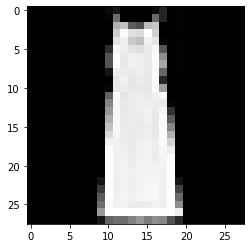

La clase obtenida es: Sandal


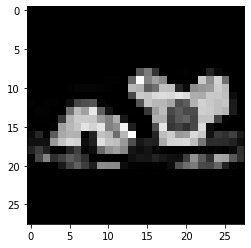

La clase obtenida es: Ankle boot


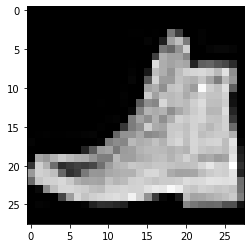

La clase obtenida es: Pullover


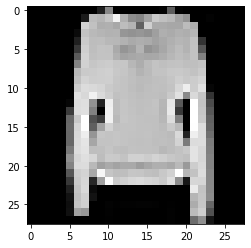

La clase obtenida es: Sneaker


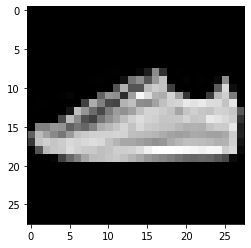

In [7]:
imgs_to_show = 5

for _ in range(imgs_to_show):

    # Cargamos un batch de imagenes
    images, images_classes = next(iter(train_loader))

    # Nos quedamos con la primera imagen del batch
    img, img_class = images[0], images_classes[0]

    # Mostramos alguna informacion de la imagen
    print(f"La clase obtenida es: {classes[img_class]}")

    # Re-escalamos y mostramos la imagen
    img = img.reshape((28, 28))
    show_img(img, color_format_range = (-1.0, 1.0))

Mostramos ahora unas cuantas imágenes de forma simultánea:

Mostramos ahora los tamaños del dataset:

In [8]:
print(f"Tenemos {len(train_dataset)} imágenes de entrenamiento")
print(f"Tenemos {len(test_dataset)} imágenes de test")

Tenemos 60000 imágenes de entrenamiento
Tenemos 10000 imágenes de test


# Definiendo el modelo base

- A continuación, definimos el modelo que vamos a usasr como base para nuestra red siamesa:

In [9]:
# TODO -- lo suyo seria usar un modelo pre-entrenado como ResNet12 como modelo base

class LuNet(nn.Module):
    """
    LuNet model adapted to 28x28x1 input images
    
    Based on the model presented in the paper "In defense of the triplet loss 
    for person re-identification"
    
    In order to make some experiments with this model
    
    Original architecture is quite similar to a common ResNet using bottleneck 
    building blocks with batch normalization. The real work happens in the 
    loss function and also the way triplets are chosen. So we are going to 
    stack some building blocks without max-pooling (28x28x1 is small enough)
    and apply that loss function and triplet selection policy
    
    
    """
    
    def __init__(self):          
        # Init parent class
        super().__init__()

        # ResNet Blocks
        self.block1 = BottleNeckBlock(
            input_channels = 1,
            output_channels = 8,
            kernel_size = 3,
            stride = 1,
            disable_identity = True,
        )
        
        self.block2 = BottleNeckBlock(
            input_channels = 8,
            output_channels = 8,
            kernel_size = 3,
            stride = 1,
            disable_identity = False,
        )
        
        self.block3 = BottleNeckBlock(
            input_channels = 8,
            output_channels = 16,
            kernel_size = 3,
            stride = 1,
            disable_identity = True,
        )
        
        self.block4 = BottleNeckBlock(
            input_channels = 16,
            output_channels = 16,
            kernel_size = 3,
            stride = 1,
            disable_identity = False,
        )
        
        # Fully connected layers
        # We end up with an embedding space of dimension 64
        self.fc1 = nn.Linear(12544, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ResNet blocks
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        
        # Now fully-connected layers
        x = torch.flatten(x, start_dim = 1)
        
        x = self.fc1(x)
        # TODO -- enable this again
        #x = self.bn1(x)
        x = F.relu(x)        
        x = self.fc2(x)
        
        return x

# Generación de triples

- Para entrenar la red siamesa, necesitamos dar triples con los que computar el *triplet loss*
- Por ello, es necesaria una fase previa de *triplets mining*
- En todos los casos, crearemos *Datasets* de *Pytorch* para representar la creación de los triples
- Hacemos esto basándonos el la [documentación oficial de Pytorch](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)

## Generación de triples aleatorios

- Es la forma más sencilla y directa para generar triples
- Usaremos esta generación como baseline para más tarde realizar comparaciones

In [10]:
# TODO -- hay que implementar esto
from torch.utils.data import RandomSampler


class RandomTriplets(Dataset):
    """
    Dataset en el que los elementos son triples obtenidos de forma aleatoria
    """

    def __init__(self, base_data: Dataset, custom_len: int, transform = None):
        self.base_data = base_data
        self.custom_len = custom_len
        self.transform = transform
        self.random_sampler = RandomSampler(self.base_data, replacement=True, num_samples=1, generator=None)

    def __len__(self):
        """
        Devolvemos el tamaño del dataset
        Como estamos generando triples aleatorios, devolvemos el tamaño definido
        por parametro
        """
        return self.custom_len

    def __getitem__(self, idx) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Funcion que es llamada cuando se hace dataset[idx]
        En vez de devolver una imagen (que es lo comun en esta clase dataset), 
        devolvemos un triple (anchor, positive, negative) aleatorio
        """

        # Hacemos esto por temas de eficiencia
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Tomamos una imagen aleatoria que sera el ancla
        anchor, anchor_class = self.base_data[next(iter(self.random_sampler))]

        # Tomamos una imagen de la misma clase, que sera la positiva
        # TODO -- hay que hacer que de algun modo sea de la misma clase
        positive, positive_class = self.base_data[next(iter(self.random_sampler))]

        # Tomamos una imagen de otra clase, que sera la negativa
        # TODO -- hay que hacer que de algun modo sea de una clase distinta
        negative, negative_class = self.base_data[next(iter(self.random_sampler))]

        # TODO -- borrar este logging porque va a hacer que vaya mas lento
        print(f"La clase anchor es {anchor_class}")
        print(f"La clase positiva es {positive_class}")
        print(f"La clase negativa es {negative_class}")
        
        # Generamos ahora el triple
        triplet = [anchor, positive, negative]

        # Aplicamos la transformacion dada al dataset al ejemplo que devolvemos
        if self.transform:
            triplet = [self.transform(img) for img in triplet]

        return triplet


random_triplets = RandomTriplets(
    base_data = train_dataset,
    custom_len = len(train_dataset) * 3,
    transform = transform
)

custom_triplet = random_triplets[2]
print("Funciona")

La clase anchor es 9
La clase positiva es 7
La clase negativa es 7


TypeError: ignored

# Entrenamiento del modelo

In [ ]:
# Set the training parameters
parameters = dict()
parameters["lr"] = 0.001
parameters["momentum"] = 0.9
parameters["criterion"] = triplet_loss_batch_hard
parameters["epochs"] = 10

# We save the model in different paths wether we're running
# local or in cloud
# TODO -- esto ponerlo en constantes y con buenos nombres
save_model_path = None
if RUNNING_ENV == "local": save_model_path = "./saved_models"
if RUNNING_ENV == "remote": save_model_path = "drive/MyDrive/ml/Modelos/MNIST-ReID/saved_models"

# Network we are going to train
net = LuNet()

# Specifying the trainning logger
logger = TripletLogger(
    iterations = 200 * batch_size, # TODO -- document why multiplying batch_size 
    loss_func = triplet_loss_batch_hard, 
    net = net,
    training_perc = 0.2, 
    validation_perc = 1.0
)

# If running in cloud, show tensorboard inline
if RUNNING_ENV == "remote":
    %load_ext tensorboard
    %tensorboard --logdir runs

# Train process
core.batch_hard_train(
    net, 
    save_model_path, 
    parameters, 
    train_loader = train_loader, 
    validation_loader = test_loader, # TODO -- we are using test dataset as validation dataset 
    name = "LuNet", 
    logger = logger,
    snapshot_iterations = 10_000 
)

# Close the logger when we are done with the training
logger.close()

# Evaluación del modelo

- Mostramos algunas métricas fundamentales sobre el conjunto de

In [ ]:
# TODO -- hay que implementar algunas metricas

# Adaptación del modelo para usarlo como clasificador

- Nuestro modelo genera un *embedding*
- Adaptamos el modelo para que, a partir de dicho embedding, podamos usarlo como un clasificador

In [ ]:
# TODO -- adaptar el modelo

## Evaluación del clasificador obtenido

- Ahora que hemos adaptado el modelo para usarlo como clasificador, podemos consultar ciertas métricas de clasificación

In [ ]:
# TODO -- implementar las métricas de clasificación